In [1]:
import sys
from astropy import units as un, constants as cons
from astropy.cosmology import Planck18 as cosmo
import numpy as np
import scipy.interpolate
from latexify import latexify
from matplotlib import pyplot as plt
import cmasher as cmr
from astropy.visualization import quantity_support
quantity_support()

sys.path.append('../pysrc/')
import solve_ode as CF
import cooling_flow as CFO

import HaloPotential_new as Halo
import WiersmaCooling as Cool

import importlib

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
# Cosmology
print(cosmo)
rho_crit = cosmo.critical_density0
rho_mean = cosmo.Om0*rho_crit
delta_c =  18 * np.pi**2 + 82 * (cosmo.Om0 - 1) - 39 * (cosmo.Om0 - 1)**2 #Bryan & Norman 98

mu = 0.62 

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)


In [3]:
# Helper function for dervied values
def calc_r_vir(M_vir):
    r_vir = np.power(M_vir / (4/3) / np.pi / delta_c / rho_crit, 1/3)
    return r_vir.to('kpc')

def calc_r_200_c(M_vir):
    r_vir = np.power(M_vir / (4/3) / np.pi / 200 / rho_crit, 1/3)
    return r_vir.to('kpc')
    
def calc_r_200_m(M_vir):
    r_vir = np.power(M_vir / (4/3) / np.pi / 200 / rho_mean, 1/3)
    return r_vir.to('kpc')

def calc_T_vir(M_vir):
    r_vir = calc_r_vir(M_vir)
    vc = np.sqrt(cons.G * M_vir / r_vir)
    temp = mu*cons.m_p*vc**2/cons.k_B/2
    return temp.to('K')

def calc_concentration(M_vir):
    h = cosmo.H0.value/100
    M_ref = 1e12/h * un.Msun
    log_c = 0.905 - 0.101*np.log10(M_vir/M_ref)
    return np.power(10, log_c)

def circular_temp(vc):
    temp = 0.6*mu*cons.m_p*vc**2/cons.k_B
    return temp.to('K')

In [4]:
# Parameters
M_vir = 1e11 * un.Msun
r_vir = calc_r_vir(M_vir)
T_vir = calc_T_vir(M_vir)
c_vir = calc_concentration(M_vir) # Concentration parameter
r_200_m = calc_r_200_m(M_vir)
r_200_c = calc_r_200_c(M_vir)
M_gal = 1e10 * un.Msun # Greco et al 2012 for M82
r_gal = 0.015*r_200_c # Kravtsoc 2013 expression for stellar half-mass radius
z_gal = 0.15 * un.kpc # Lim et al 2013 for M82
      
print("Halo Mass: ",M_vir)
print("Virial Radius: ", r_vir)
print("Virial Temperature: ", T_vir)
print("Concentration Parameter: ", c_vir)
print("R200m: ", r_200_m)
print("R200c: ", r_200_c)
print("Disk Mass", M_gal)
print("Disk Scale Radius", r_gal)
print("Disk Scale Height", z_gal)

nfw = Halo.NFWPotential(M_vir, r_vir, c_vir)
plummer = Halo.PlummerPotential(M_gal, r_gal)
outer = Halo.OuterHaloPotential(rho_mean, r_200_m)
combined = Halo.CombinedPotential(M_vir, r_vir, c_vir, M_gal, r_gal, rho_mean, r_200_m)

print("NFW Scale Density: ", nfw.rho_s)

Halo Mass:  100000000000.0 solMass
Virial Radius:  122.40315626626357 kpc
Virial Temperature:  131960.7175211719 K
Concentration Parameter:  10.54718269190388
R200m:  144.76736317842207 kpc
R200c:  97.94126310709676 kpc
Disk Mass 10000000000.0 solMass
Disk Scale Radius 1.4691189466064514 kpc
Disk Scale Height 0.15 kpc
NFW Scale Density:  3320989.038326563 solMass / kpc3


In [5]:
cu_len = 1.0 * un.kpc
cu_mass = 3.036951775493658e+39 * un.g # number density 0.1 cm^-3 
cu_density = cu_mass / cu_len**3

print("Input Parameters in Code Units")
print(f"r_scale   = {(combined.r_s/cu_len).to('')}")
print(f"rho_scale = {(combined.rho_s/cu_density).to('')}")
print(f"mass_gal  = {(combined.M_gal/cu_mass).to('')}")
print(f"scale_gal = {(combined.a_gal/cu_len).to('')}")
print(f"r_200     = {(combined.R200/cu_len).to('')}")
print(f"rho_mean  = {(combined.rho_mean/cu_density).to('')}")


Input Parameters in Code Units
r_scale   = 11.605294024177795
rho_scale = 2.1743800601559324
mass_gal  = 6547.387043624801
scale_gal = 1.4691189466064514
r_200     = 144.76736317842207
rho_mean  = 2.5759499304527406e-05


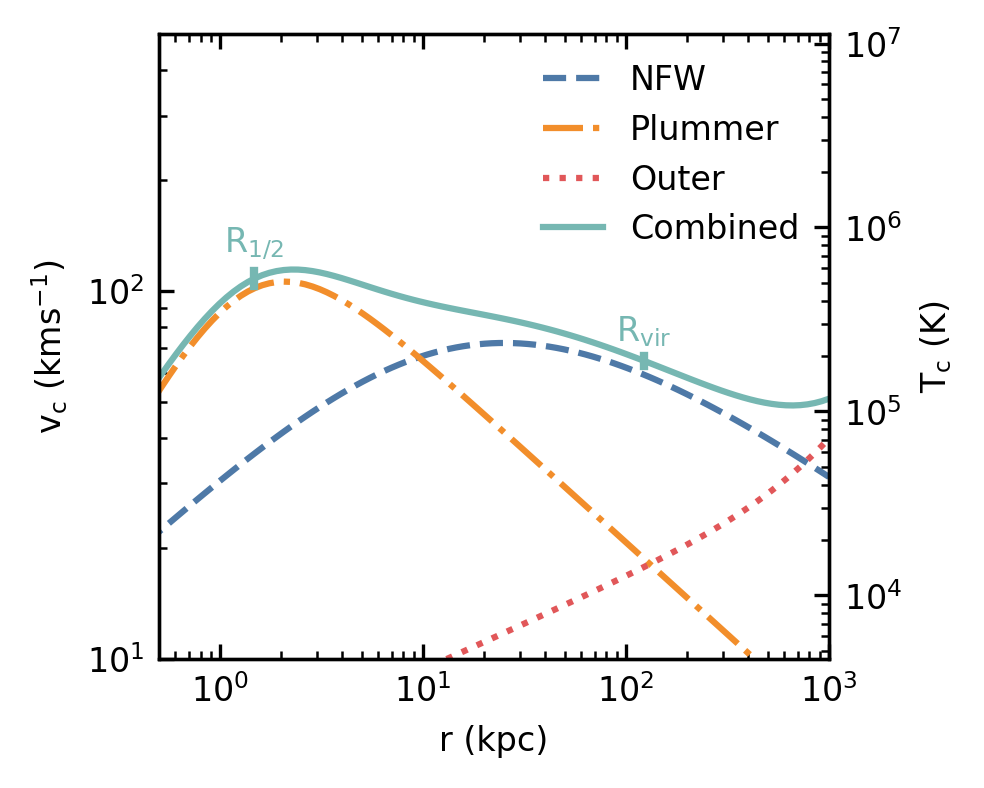

In [88]:
# Plot the circular velocity and its components
rs = np.logspace(-0.5,3,100) * un.kpc

cvs = nfw.vc(rs)
p_cvs = plummer.vc(rs)
o_cvs = outer.vc(rs)
c_cvs = combined.vc(rs)

latexify(columns=1)
plt.figure()
ax=plt.gca()
ax.tick_params(top=True, right=True, which="both", direction='in')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5,1000)
plt.ylim(10,500)

plt.plot(rs,cvs,ls='--',label="NFW")
plt.plot(rs,p_cvs,ls='-.',label="Plummer")
plt.plot(rs,o_cvs,ls=':',label="Outer")
plt.plot(rs,c_cvs,ls='-',label="Combined")

tick_length = 2
ticks = [r_vir,r_200_m,r_200_c,r_gal]
tick_labels = [r'R$_{\rm vir}$', r'R$_{\rm 200m}$', r'R$_{\rm 200c}$', r'R$_{\rm 1/2}$']
label_dirs = [-3,1,1,1]

tick_length = 2
plt.plot([r_vir.value,r_vir.value], 
         [combined.vc(r_vir).value - tick_length, combined.vc(r_vir).value + tick_length], 
         color="C3", lw=2)
plt.text(r_vir.value,combined.vc(r_vir).value + tick_length * 2.5, r'R$_{\rm vir}$',
         color="C3", ha='center', va='bottom')

tick_length = 5
plt.plot([r_gal.value,r_gal.value], 
         [combined.vc(r_gal).value - tick_length, combined.vc(r_gal).value + tick_length], 
         color="C3", lw=2)
plt.text(r_gal.value,combined.vc(r_gal).value + tick_length * 2.5, r'R$_{\rm 1/2}$',
         color="C3", ha='center', va='bottom')

plt.xlabel('r (kpc)')
plt.ylabel(r'v$_{\rm c}$ (kms$^{-1}$)')
plt.legend(frameon=False, handlelength=1.8)

ax2 = ax.twinx() 
ax2.tick_params(which="both", direction='in')
ax2.set_yscale('log')
ax2.set_ylabel(r'T$_{\rm c}$ (K)') 
ax2.set_ylim(circular_temp(10*un.km/un.s),circular_temp(500*un.km/un.s))

plt.tight_layout()
plt.savefig('./plots/v_circ.pdf',dpi=150)
plt.show()

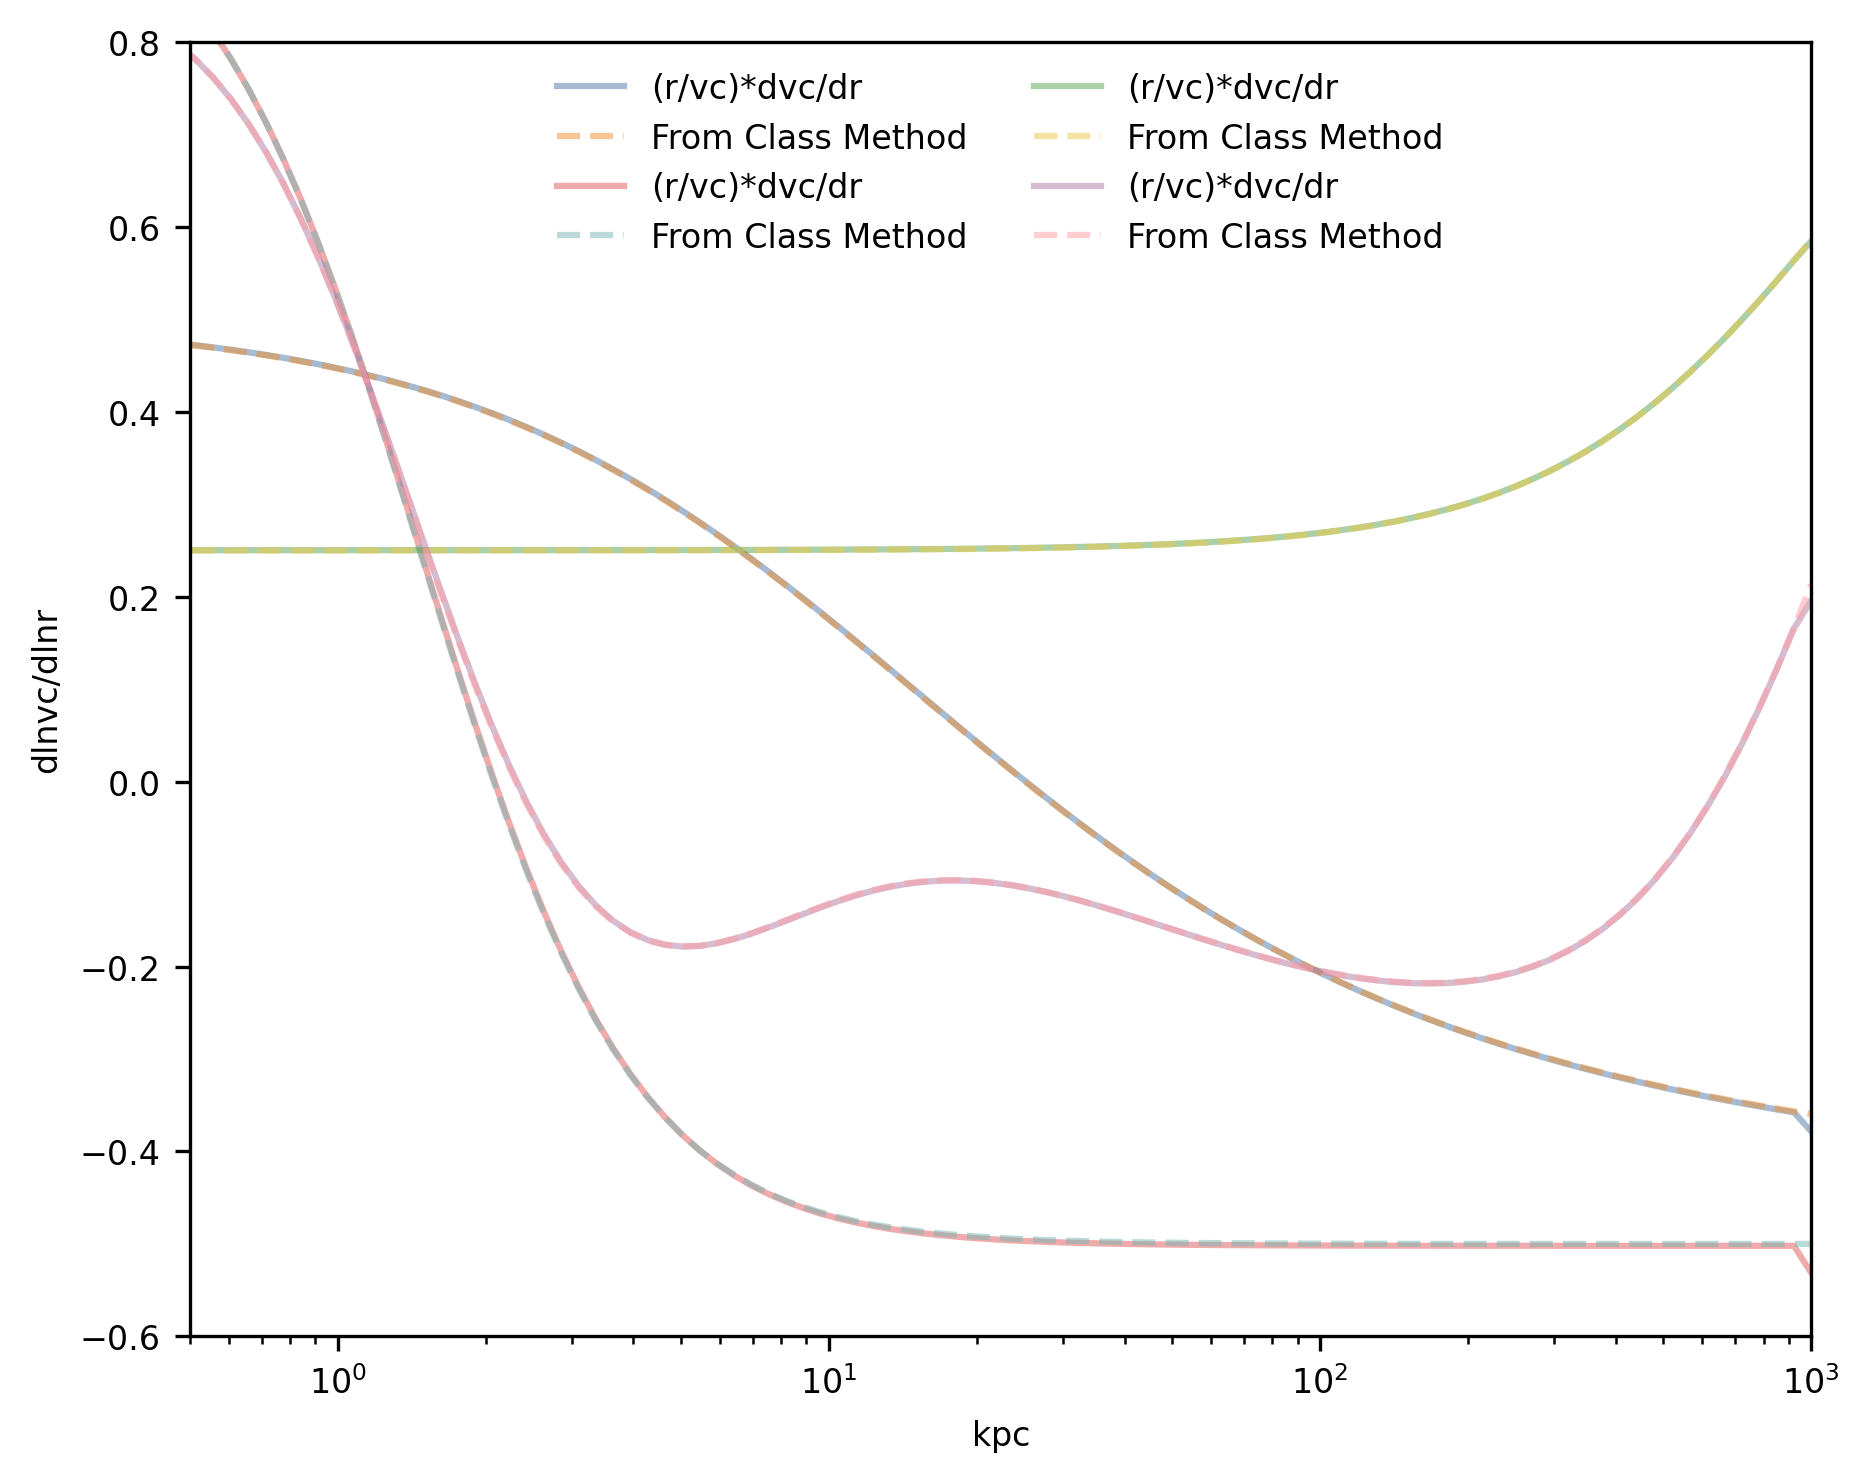

In [89]:
# Check that dlnvc/dlnr has been implemented correctly 
latexify(columns=2)
plt.figure()

plt.plot(rs,(rs.value/cvs.value)*np.gradient(cvs.value,rs.value),alpha=0.5,label='(r/vc)*dvc/dr')
plt.plot(rs,nfw.dlnvc_dlnR(rs),alpha=0.5,ls='--',label='From Class Method')

plt.plot(rs,(rs.value/p_cvs.value)*np.gradient(p_cvs.value,rs.value),alpha=0.5,label='(r/vc)*dvc/dr')
plt.plot(rs,plummer.dlnvc_dlnR(rs),alpha=0.5,ls='--',label='From Class Method')

plt.plot(rs,(rs.value/o_cvs.value)*np.gradient(o_cvs.value,rs.value),alpha=0.5,label='(r/vc)*dvc/dr')
plt.plot(rs,outer.dlnvc_dlnR(rs),alpha=0.5,ls='--',label='From Class Method')

plt.plot(rs,(rs.value/c_cvs.value)*np.gradient(c_cvs.value,rs.value),alpha=0.5,label='(r/vc)*dvc/dr')
plt.plot(rs,combined.dlnvc_dlnR(rs),alpha=0.5,ls='--',label='From Class Method')

plt.ylabel('dlnvc/dlnr')
plt.legend(frameon=False, ncols=2)
plt.xscale('log')
plt.xlim(0.5,1000)
plt.ylim(-0.6,0.8)
plt.show()

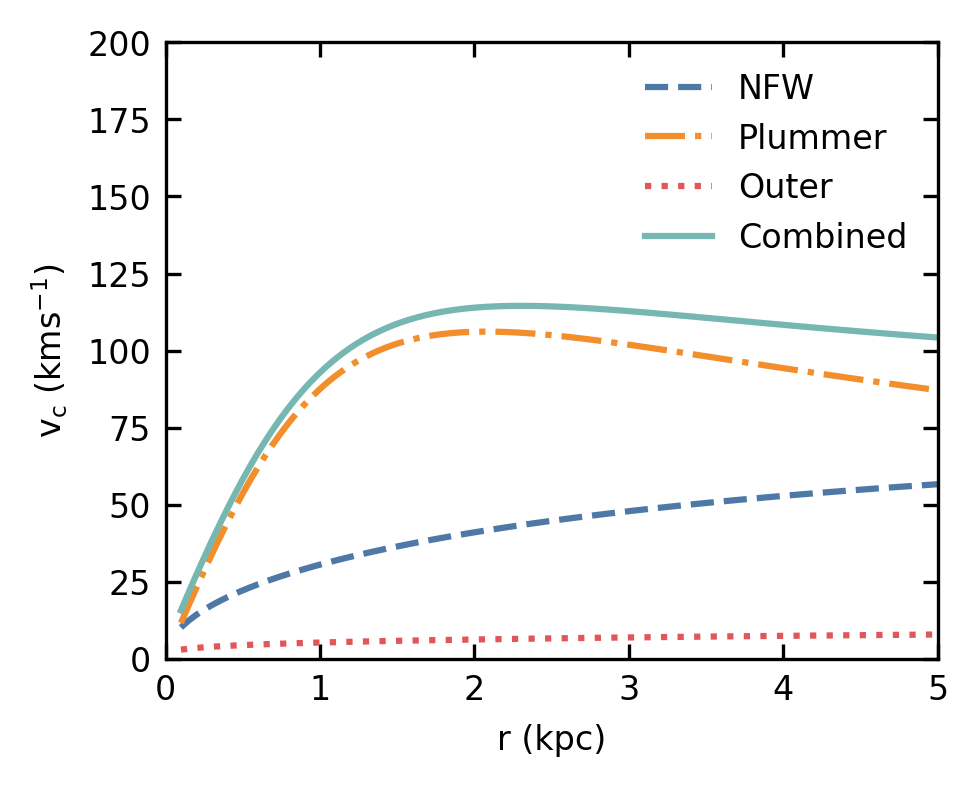

In [90]:
# Plot the circular velocity and its components
# This is in the inner region to compare with observed rotation curves in Greco et al 2012 for M82
# The main difference is we are using a R1/2 that is larger by about a factor of 2
rs = np.linspace(0.1,5,100) * un.kpc

cvs = nfw.vc(rs)
p_cvs = plummer.vc(rs)
o_cvs = outer.vc(rs)
c_cvs = combined.vc(rs)

latexify(columns=1)
plt.figure()
ax=plt.gca()
ax.tick_params(top=True, right=True, which="both", direction='in')
plt.xlim(0,5)
plt.ylim(0,200)

plt.plot(rs,cvs,ls='--',label="NFW")
plt.plot(rs,p_cvs,ls='-.',label="Plummer")
plt.plot(rs,o_cvs,ls=':',label="Outer")
plt.plot(rs,c_cvs,ls='-',label="Combined")

plt.xlabel('r (kpc)')
plt.ylabel(r'v$_{\rm c}$ (kms$^{-1}$)')
plt.legend(frameon = False)

plt.show()

In [6]:
# Set Cooling
# importlib.reload(Cool)
cooling = Cool.Wiersma_Cooling(Z2Zsun=1/3,z=0)

/mnt/home/btan1/Work/CGM_ICs/ipynb/../pysrc/WiersmaCooling.py:54: RuntimeWarning: invalid value encountered in log10
  vals = log(self.LAMBDA(X*un.K,Y*un.cm**-3).value)


In [9]:
un_phi = cu_velocity**2

x1l = 125.976562*un.kpc
x2v = 110.351562*un.kpc
x3v = -235.351562*un.kpc

r_ = np.sqrt(x1l**2 + x2v**2 + x3v**2)

vc = combined.vc(r_)
vc_ = (vc/cu_velocity).to('')
dphi_dr = vc_**2/(r_/cu_len).to('')
print(-dphi_dr)

delta_r = 0.00005*un.kpc
phil = combined.Phi(r_ - delta_r)
phir = combined.Phi(r_ + delta_r)
dphi_dr_= (phil-phir)/(2*delta_r)
print((dphi_dr_*cu_length/cu_velocity**2).to(''))

-0.1051445211916659
-0.1051445212235625


In [10]:
importlib.reload(CF)
max_step = 0.01                          # lowest resolution of solution in ln(r)
R_min    = 1*un.kpc                      # inner radius of supersonic part of solution
R_max    = 300*un.kpc                    # outer radius of integration
R_sonic  = 30*un.kpc                     # sonic radii

print('R_sonic = %s'%R_sonic)
sol = CF.shoot_from_R_sonic(combined,cooling,R_sonic,R_max,R_min,max_step=max_step,verbose=True)

R_sonic = 30.0 kpc
Integrating with v_c^2/c_s^2 (R_sonic) = 1.000010 ... Stop reason: Starts unbound
Integrating with v_c^2/c_s^2 (R_sonic) = 1.500005 ... Stop reason: Sonic point (Maximum r = 53 kpc)
Integrating with v_c^2/c_s^2 (R_sonic) = 1.250008 ... Stop reason: Unbound (Maximum r = 43 kpc)
Integrating with v_c^2/c_s^2 (R_sonic) = 1.375006 ... Stop reason: Unbound (Maximum r = 63 kpc)
Integrating with v_c^2/c_s^2 (R_sonic) = 1.437506 ... Stop reason: Unbound (Maximum r = 94 kpc)
Integrating with v_c^2/c_s^2 (R_sonic) = 1.468755 ... Stop reason: Sonic point (Maximum r = 288 kpc)
Integrating with v_c^2/c_s^2 (R_sonic) = 1.453130 ... Stop reason: Unbound (Maximum r = 117 kpc)
Integrating with v_c^2/c_s^2 (R_sonic) = 1.460943 ... Stop reason: Unbound (Maximum r = 145 kpc)
Integrating with v_c^2/c_s^2 (R_sonic) = 1.464849 ... Stop reason: Unbound (Maximum r = 186 kpc)
Integrating with v_c^2/c_s^2 (R_sonic) = 1.466802 ... Stop reason: Max R reached (Maximum r = 299 kpc)
Inward integrati

In [8]:
# units
cu_length  = 3.0856775809623245e+21 * un.cm # kpc
cu_mass    = 3.036951775493658e+39 * un. g  # number density 0.1 cm^-3 when box size is 1 kpc
cu_time    = 3.15576e+15  * un.s            # 100 Myr
mu         = 0.62                           # mean molecular weight

cu_velocity = cu_length/cu_time # cm/s
cu_density = cu_mass/cu_length**3 # g/cm**3
cu_energy = cu_mass*cu_velocity**2 # erg
cu_pressure = cu_energy/cu_length**3 # erg/cm**3 or dyne/cm^2
cu_temperature = cu_velocity**2*mu*cons.m_p/cons.k_B # K

In [11]:
Rs = (sol.Rs/cu_length).to('').value
Ts = (sol.Ts/cu_temperature).to('').value
rhos = (sol.rhos/cu_density).to('').value
vs = (sol.vs/cu_velocity).to('').value

"""
The file format is a header line followed by data columns:
# r T rho v
r_1 T_1 rho_1 v_1
r_2 T_2 rho_2 v_2
"""

# Combine arrays into a single array for saving
data = np.column_stack((Rs, Ts, rhos, vs))

# Save to file with header
header = "# r T rho v"
filename = "cgm_profiles.txt"
np.savetxt(filename, data, header=header)

print(f"Profiles saved to {filename}")

Profiles saved to cgm_profiles.txt


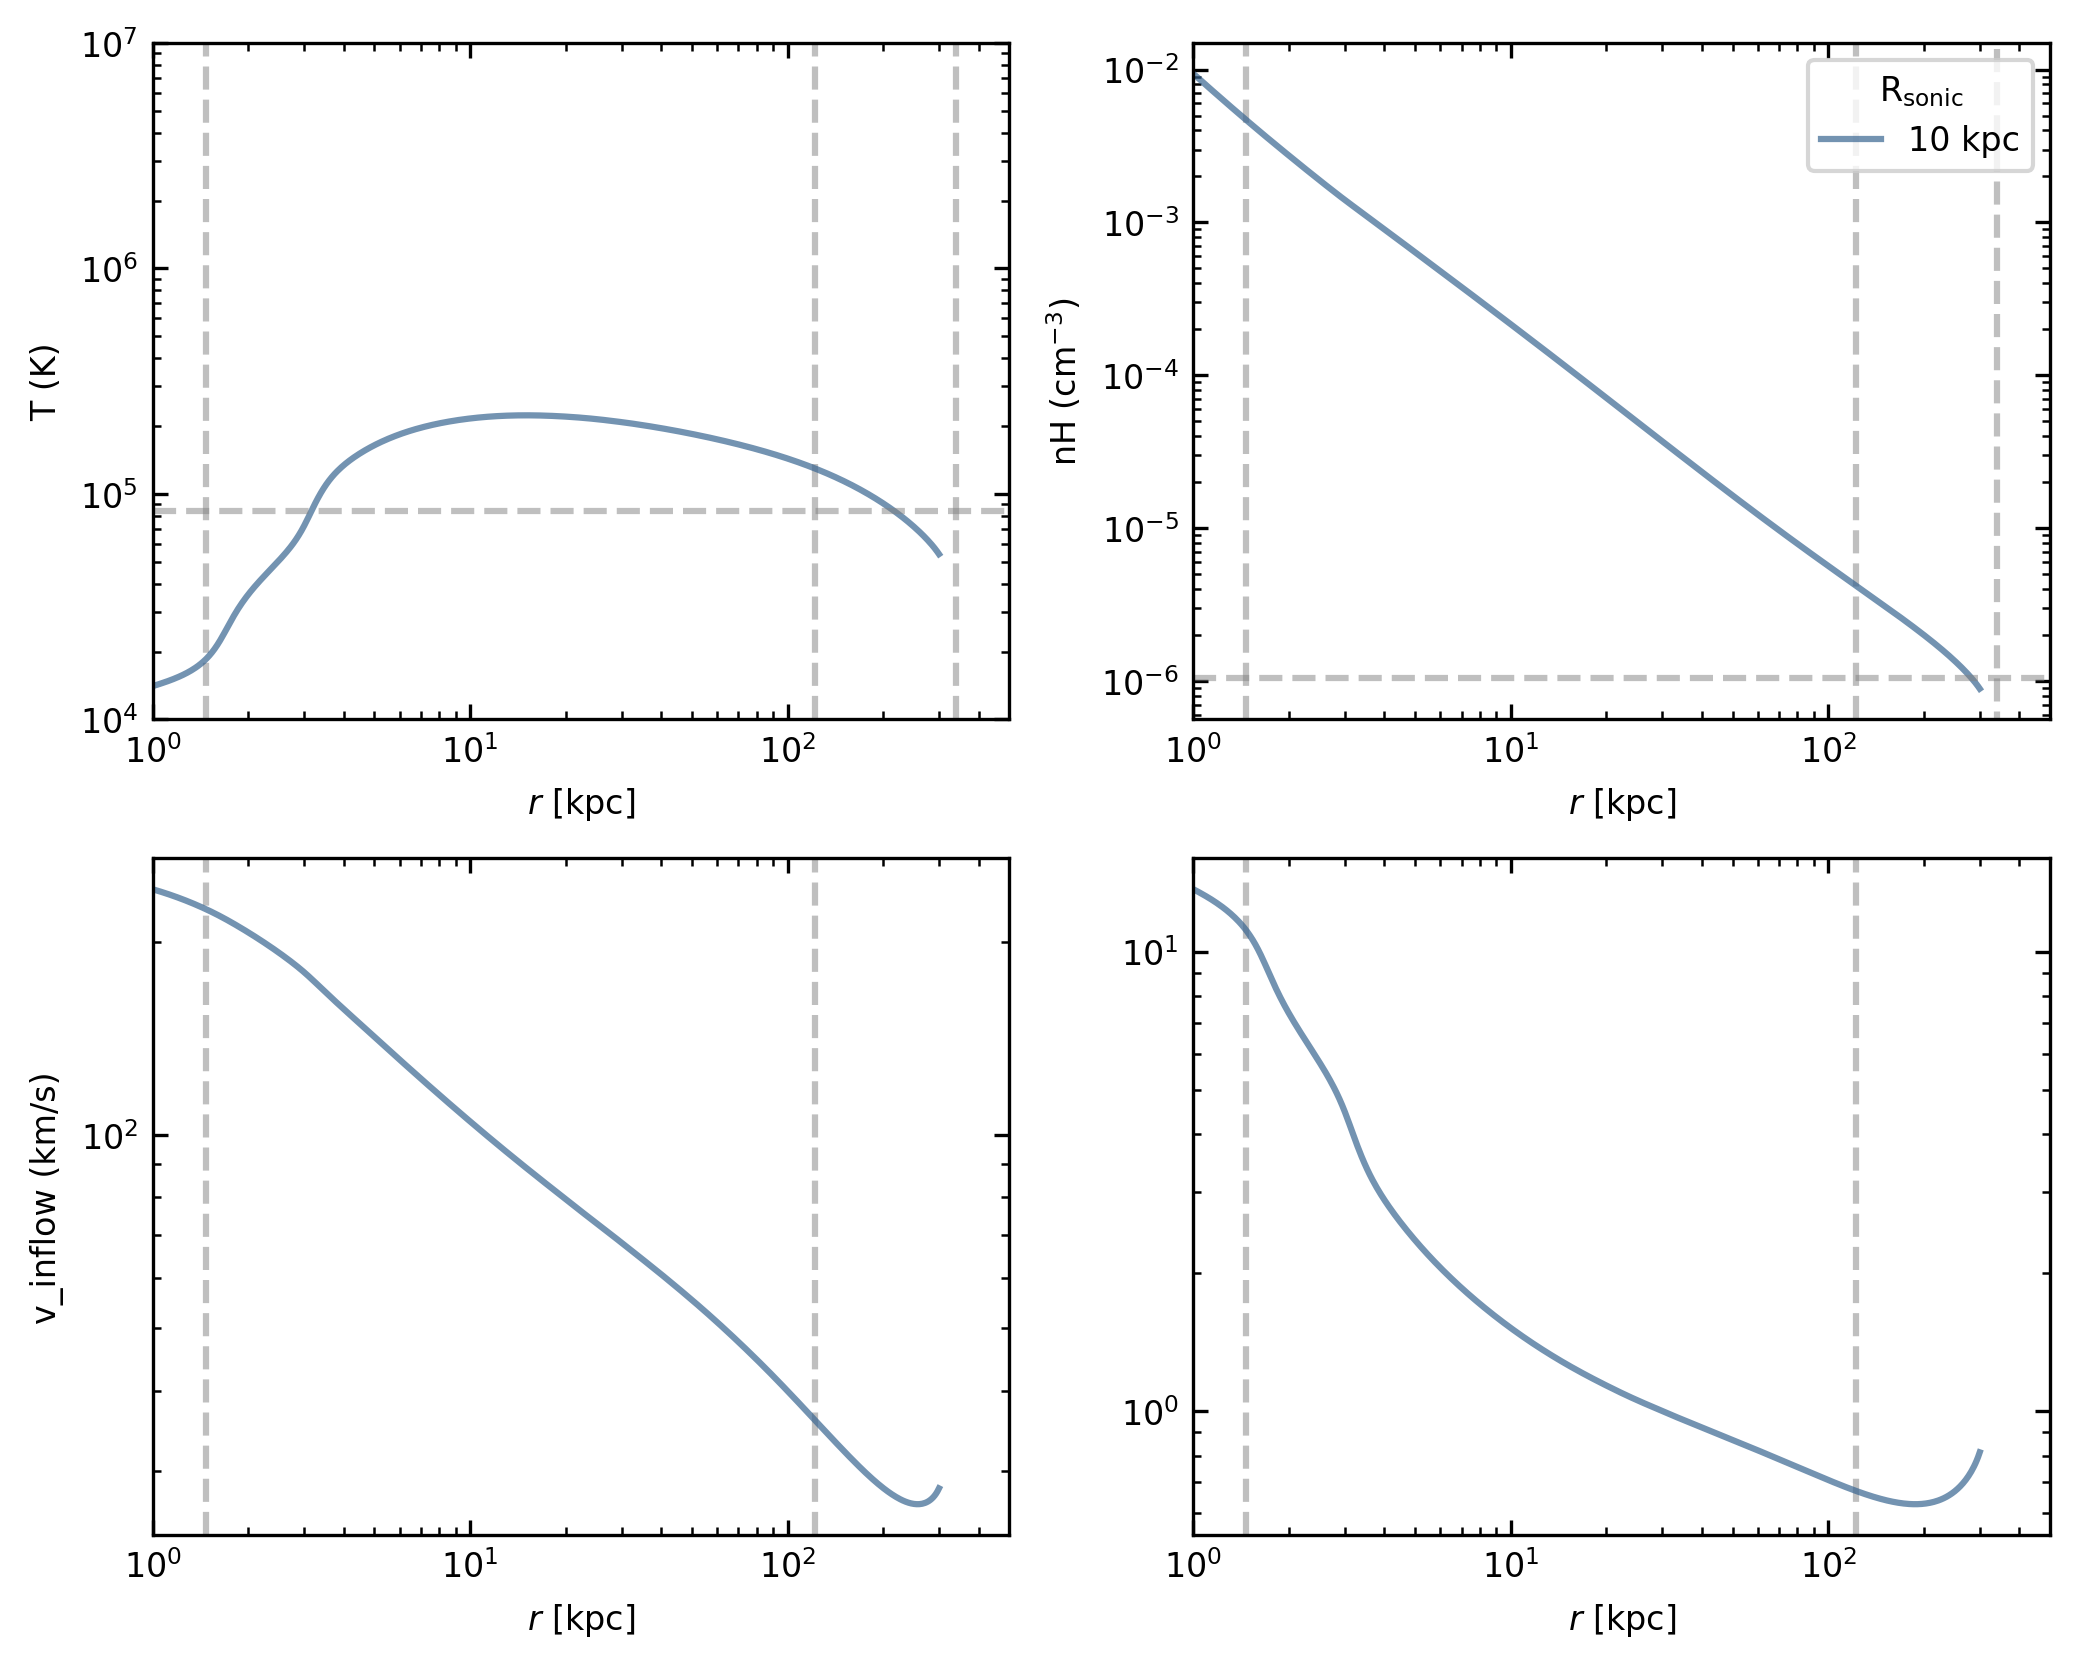

In [13]:
latexify(columns=2)
fig, axs = plt.subplots(2, 2)

for ax in axs.flatten():
    ax.set_xlabel(r'$r$ [kpc]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(top=True, right=True, which="both", direction='in')
    ax.set_xlim(1,500)

    ax.axvline(r_gal,c='.5',ls='--',alpha=0.5)
    ax.axvline(r_vir,c='.5',ls='--',alpha=0.5)

colors = cmr.lavender(np.linspace(0.2,0.8,10))

res = sol
i=5

axs[0, 0].plot(res.Rs, res.Ts, alpha=0.7, color=colors[i])
axs[0, 0].hlines(83716.961983,1,500,ls='--',color='.5',alpha=0.5)
axs[0, 0].vlines(340,1e4,1e7,ls='--',color='.5',alpha=0.5)
axs[0, 0].set_ylabel(r'T (K)')
axs[0, 0].set_ylim(1e4,1e7)

axs[0, 1].plot(res.Rs, res.nHs, alpha=0.7, color=colors[i], label=f'10 kpc')
# axs[0, 1].plot(res.Rs, res.rhos, alpha=0.7, color='red')
axs[0, 1].hlines(0.104269/1e5,1,500,ls='--',color='.5',alpha=0.5)
axs[0, 1].vlines(340, 1e-7, 1e-1, ls='--', color='.5', alpha=0.5)
axs[0, 1].set_ylabel(r'nH (cm$^{-3}$)')
# axs[0, 1].set_ylim(1e-5,1)

axs[1, 0].plot(res.Rs, res.vs, alpha=0.7, color=colors[i])
axs[1, 0].set_ylabel(r'v_inflow (km/s)')
# axs[1, 0].set_ylim(0.03,30)

axs[1, 1].plot(res.Rs, res.Ms, alpha=0.7, color=colors[i])
# axs[1, 1].set_ylabel(r'$t_{\rm cool}/t_{\rm flow}$')
# axs[1, 1].set_ylim(0.03,30)
# axs[1, 1].axhline(1.,c='.5',ls='--',alpha=0.5)

axs[0, 1].legend(frameon=True, loc='upper right', title=r'R$_{\rm sonic}$', handlelength=1.8)
plt.tight_layout()
# plt.savefig('./plots/cf_sols.pdf',dpi=150)
plt.show()

In [52]:
# importlib.reload(CF)
max_step = 0.1                           #lowest resolution of solution in ln(r)
R_min    = 1*un.kpc                      #inner radius of supersonic part of solution
R_max    = 5.*combined.r_vir             #outer radius of integration
R_sonics  = np.linspace(1,30,10)*un.kpc  #sonic radii
transsonic_solutions = []
for R_sonic in R_sonics:
    print('R_sonic = %s'%R_sonic)
    transsonic_solutions.append(CF.shoot_from_R_sonic(combined,
                                                      cooling,
                                                      R_sonic,
                                                      R_max,
                                                      R_min,
                                                      max_step=max_step,
                                                      verbose=False))
                    

R_sonic = 1.0 kpc
R_sonic = 4.222222222222222 kpc
No result reached R_max. Set return_all_results=True to check intermediate solutions.
R_sonic = 7.444444444444445 kpc
No result reached R_max. Set return_all_results=True to check intermediate solutions.
R_sonic = 10.666666666666668 kpc
R_sonic = 13.88888888888889 kpc
R_sonic = 17.11111111111111 kpc
R_sonic = 20.333333333333336 kpc
R_sonic = 23.555555555555557 kpc
R_sonic = 26.77777777777778 kpc
R_sonic = 30.0 kpc


0.49777618855855243 solMass / yr
0.6934842488572786 solMass / yr
0.7425531638340482 solMass / yr
0.8186649932311006 solMass / yr
0.8585085063278031 solMass / yr
0.9398650279516064 solMass / yr
0.9752989208024322 solMass / yr
1.0493948043814512 solMass / yr


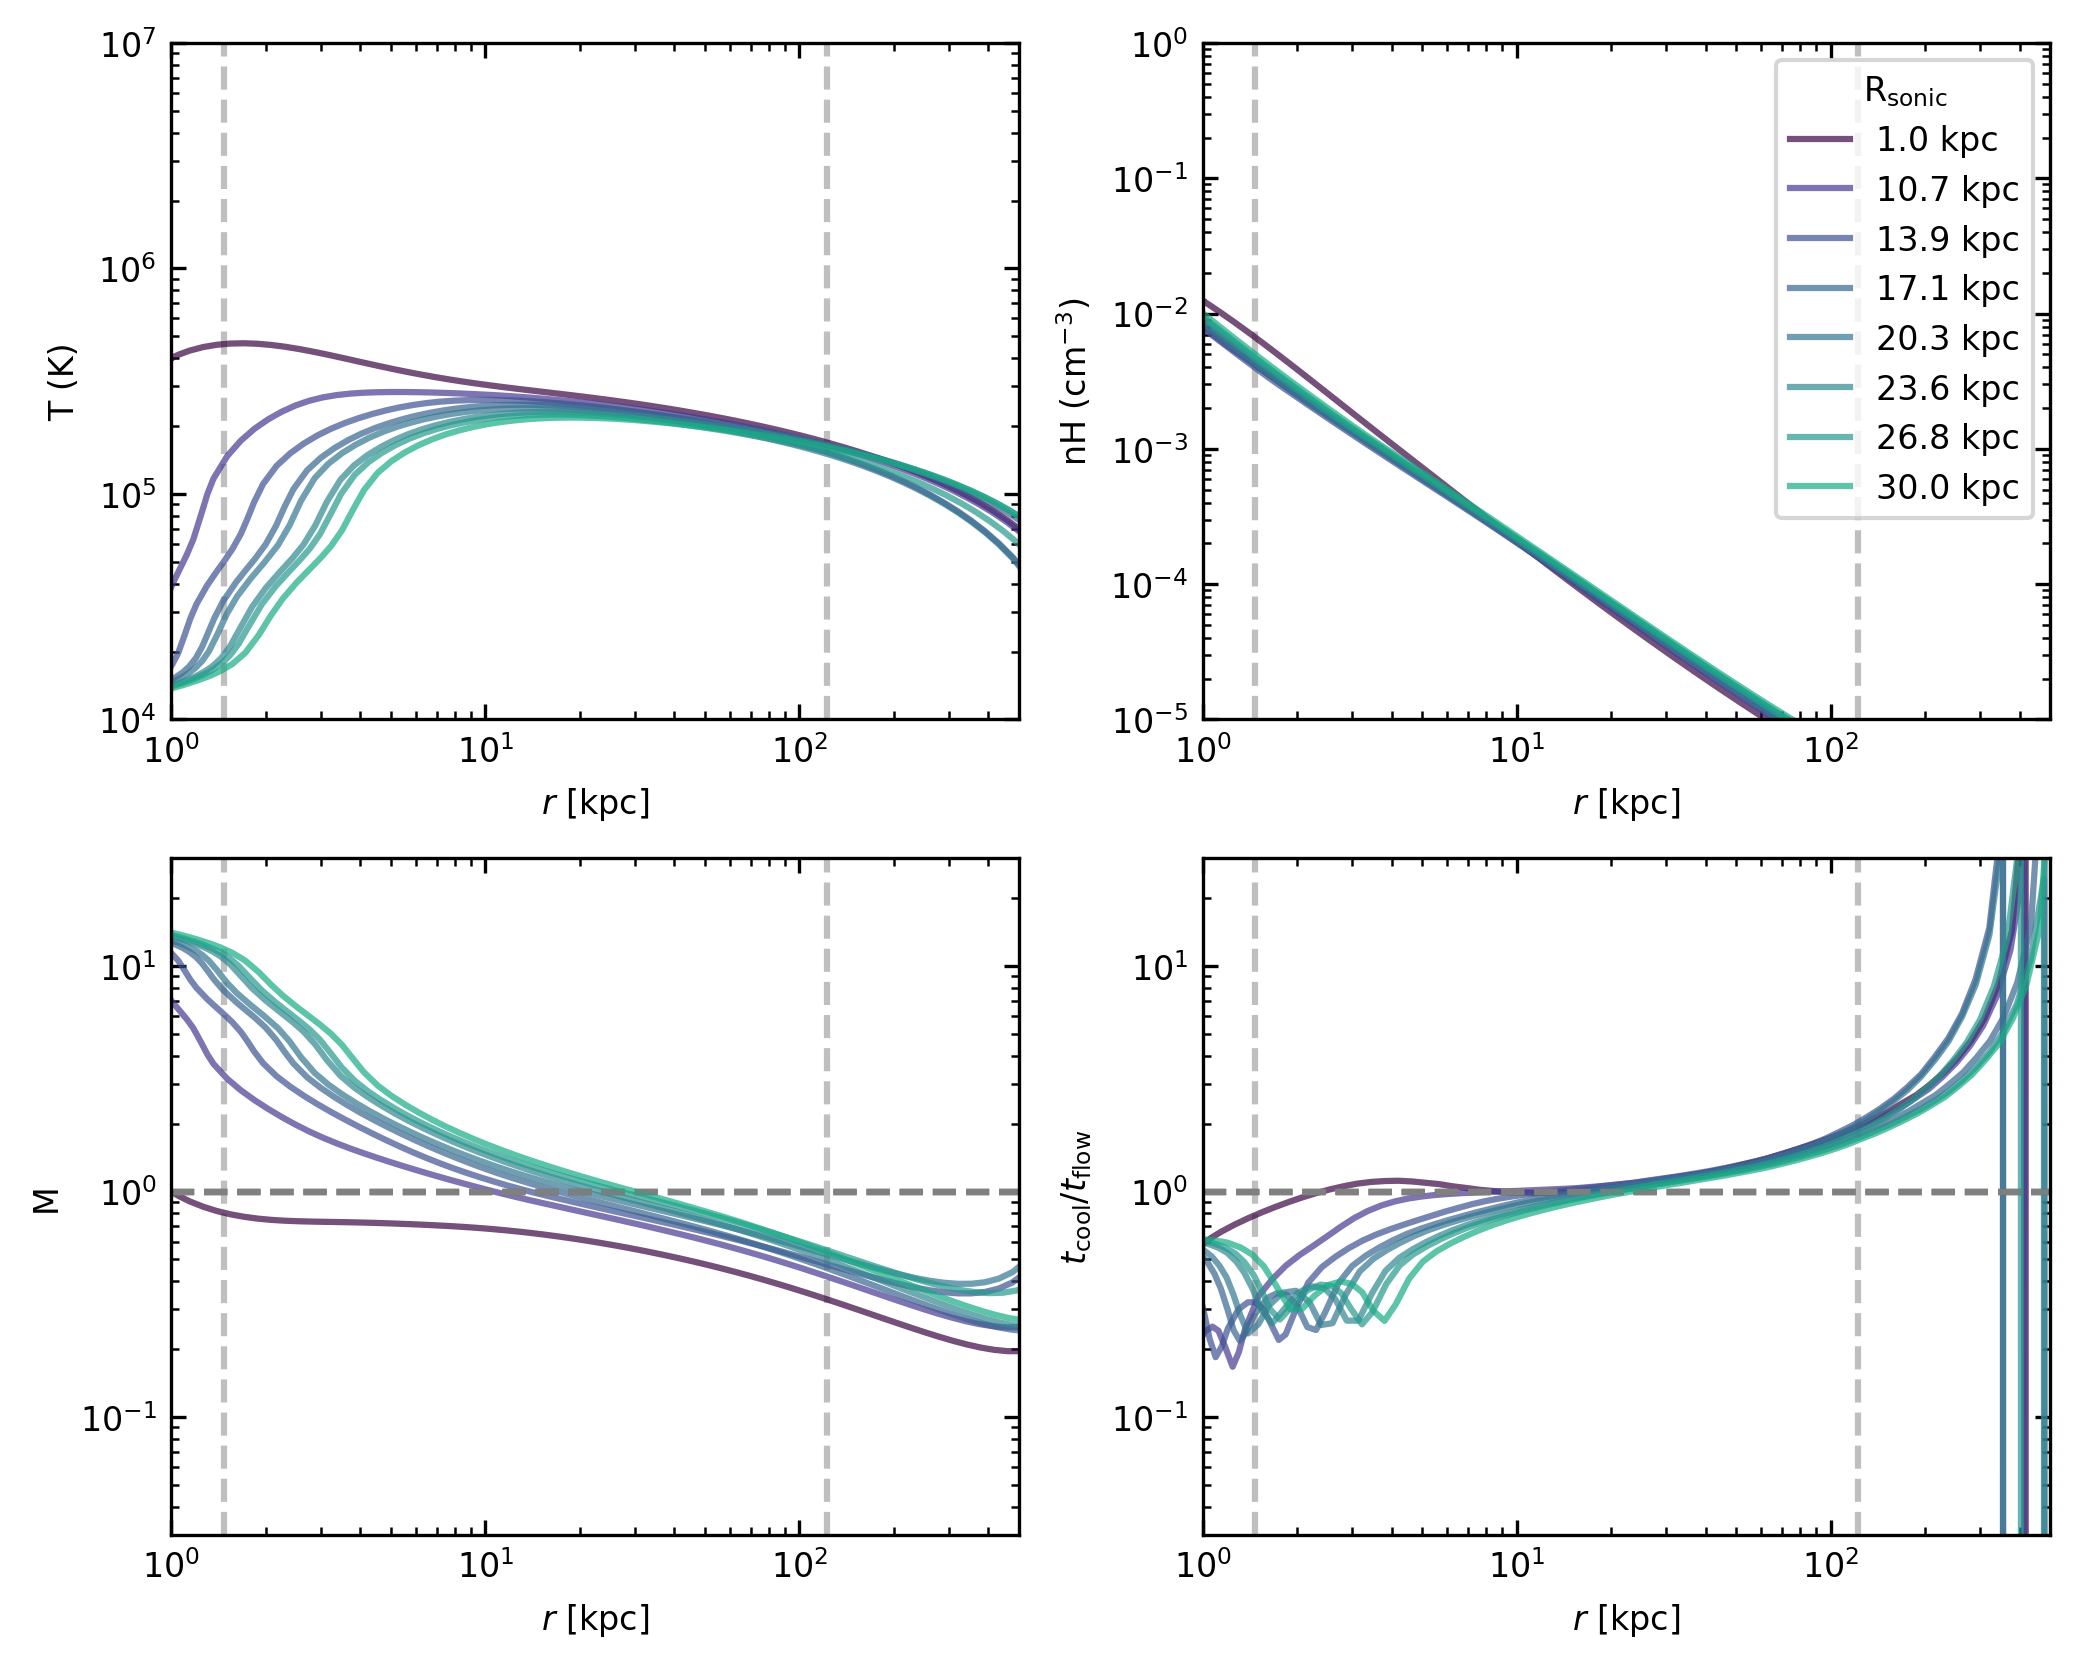

In [ ]:
latexify(columns=2)
fig, axs = plt.subplots(2, 2)

for ax in axs.flatten():
    ax.set_xlabel(r'$r$ [kpc]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(top=True, right=True, which="both", direction='in')
    ax.set_xlim(1,500)

    ax.axvline(r_gal,c='.5',ls='--',alpha=0.5)
    ax.axvline(r_vir,c='.5',ls='--',alpha=0.5)

colors = cmr.lavender(np.linspace(0.2,0.8,len(transsonic_solutions)))
for i in range(len(transsonic_solutions)):
    res = transsonic_solutions[i]
    if res is not None:
        axs[0, 0].plot(res.Rs, res.Ts, alpha=0.7, color=colors[i])
        axs[0, 0].set_ylabel(r'T (K)')
        axs[0, 0].set_ylim(1e4,1e7)
        
        axs[0, 1].plot(res.Rs, res.nHs, alpha=0.7, color=colors[i], label=f'{R_sonics[i].value:.1f} kpc')
        axs[0, 1].set_ylabel(r'nH (cm$^{-3}$)')
        axs[0, 1].set_ylim(1e-5,1)
        
        axs[1, 0].plot(res.Rs, res.Ms, alpha=0.7, color=colors[i])
        axs[1, 0].set_ylabel(r'M')
        axs[1, 0].set_ylim(0.03,30)
        axs[1, 0].axhline(1.,c='.5',ls='--',alpha=0.5)
        
        axs[1, 1].plot(res.Rs, res.t_cools / res.t_flows, alpha=0.7, color=colors[i])
        axs[1, 1].set_ylabel(r'$t_{\rm cool}/t_{\rm flow}$')
        axs[1, 1].set_ylim(0.03,30)
        axs[1, 1].axhline(1.,c='.5',ls='--',alpha=0.5)

        print(res.mass_flow_rate)

axs[0, 1].legend(frameon=True, loc='upper right', title=r'R$_{\rm sonic}$', handlelength=1.8)
plt.tight_layout()
plt.savefig('./plots/cf_sols.pdf',dpi=150)
plt.show()

In [94]:
max_step = 0.1                             # lowest resolution of solution in ln(r)
R_circ   = 1 * un.kpc                      # circularization radius
R_max    = 500 * un.kpc                    # outer radius of integration
Mdots  = [1.0]*un.Msun/un.yr  #np.logspace(-2,-1,10)*un.Msun/un.yr  # mass inflow rates
stalled_solutions = []
for Mdot in Mdots:
    print('Mdot = %s'%Mdot)
    stalled_solutions.append(CF.shoot_from_R_circ(combined,
                                                  cooling,
                                                  R_circ,
                                                  Mdot,
                                                  R_max,
                                                  v0 = 1*un.km/un.s,
                                                  max_step=max_step,
                                                  verbose=True))

Mdot = 1.0 solMass / yr
Integrating with log T(R_circ) = 4.50 ... Stop reason: Unbound (Maximum r = 1 kpc)
Integrating with log T(R_circ) = 4.25 ... Stop reason: Unbound (Maximum r = 1 kpc)
Integrating with log T(R_circ) = 4.12 ... 

/mnt/home/btan1/Work/CGM_ICs/ipynb/../pysrc/solve_ode.py:621: RuntimeWarning: overflow encountered in exp
  rho = np.exp(ln_rho) * un.g / un.cm**3
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/home/btan1/Work/CGM_ICs/ipynb/../pysrc/WiersmaCooling.py:59: RuntimeWarning: divide by zero encountered in log10
  return self.f_Cooling((log(T.to('K').value), log(nH.to('cm**-3').value))) * un.erg*un.cm**3/un.s
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/scipy/interpolate/_rgi.py

Stop reason: Unbound (Maximum r = 1 kpc)
Integrating with log T(R_circ) = 4.06 ... Stop reason: Unbound (Maximum r = 1 kpc)
Integrating with log T(R_circ) = 4.03 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.02 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.01 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.00 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.00 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.00 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.00 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.00 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.00 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.00 ... Stop reason: Unbound (Maximum r = 2 kpc)
Integrating with log T(R_circ) = 4.00 ... Stop

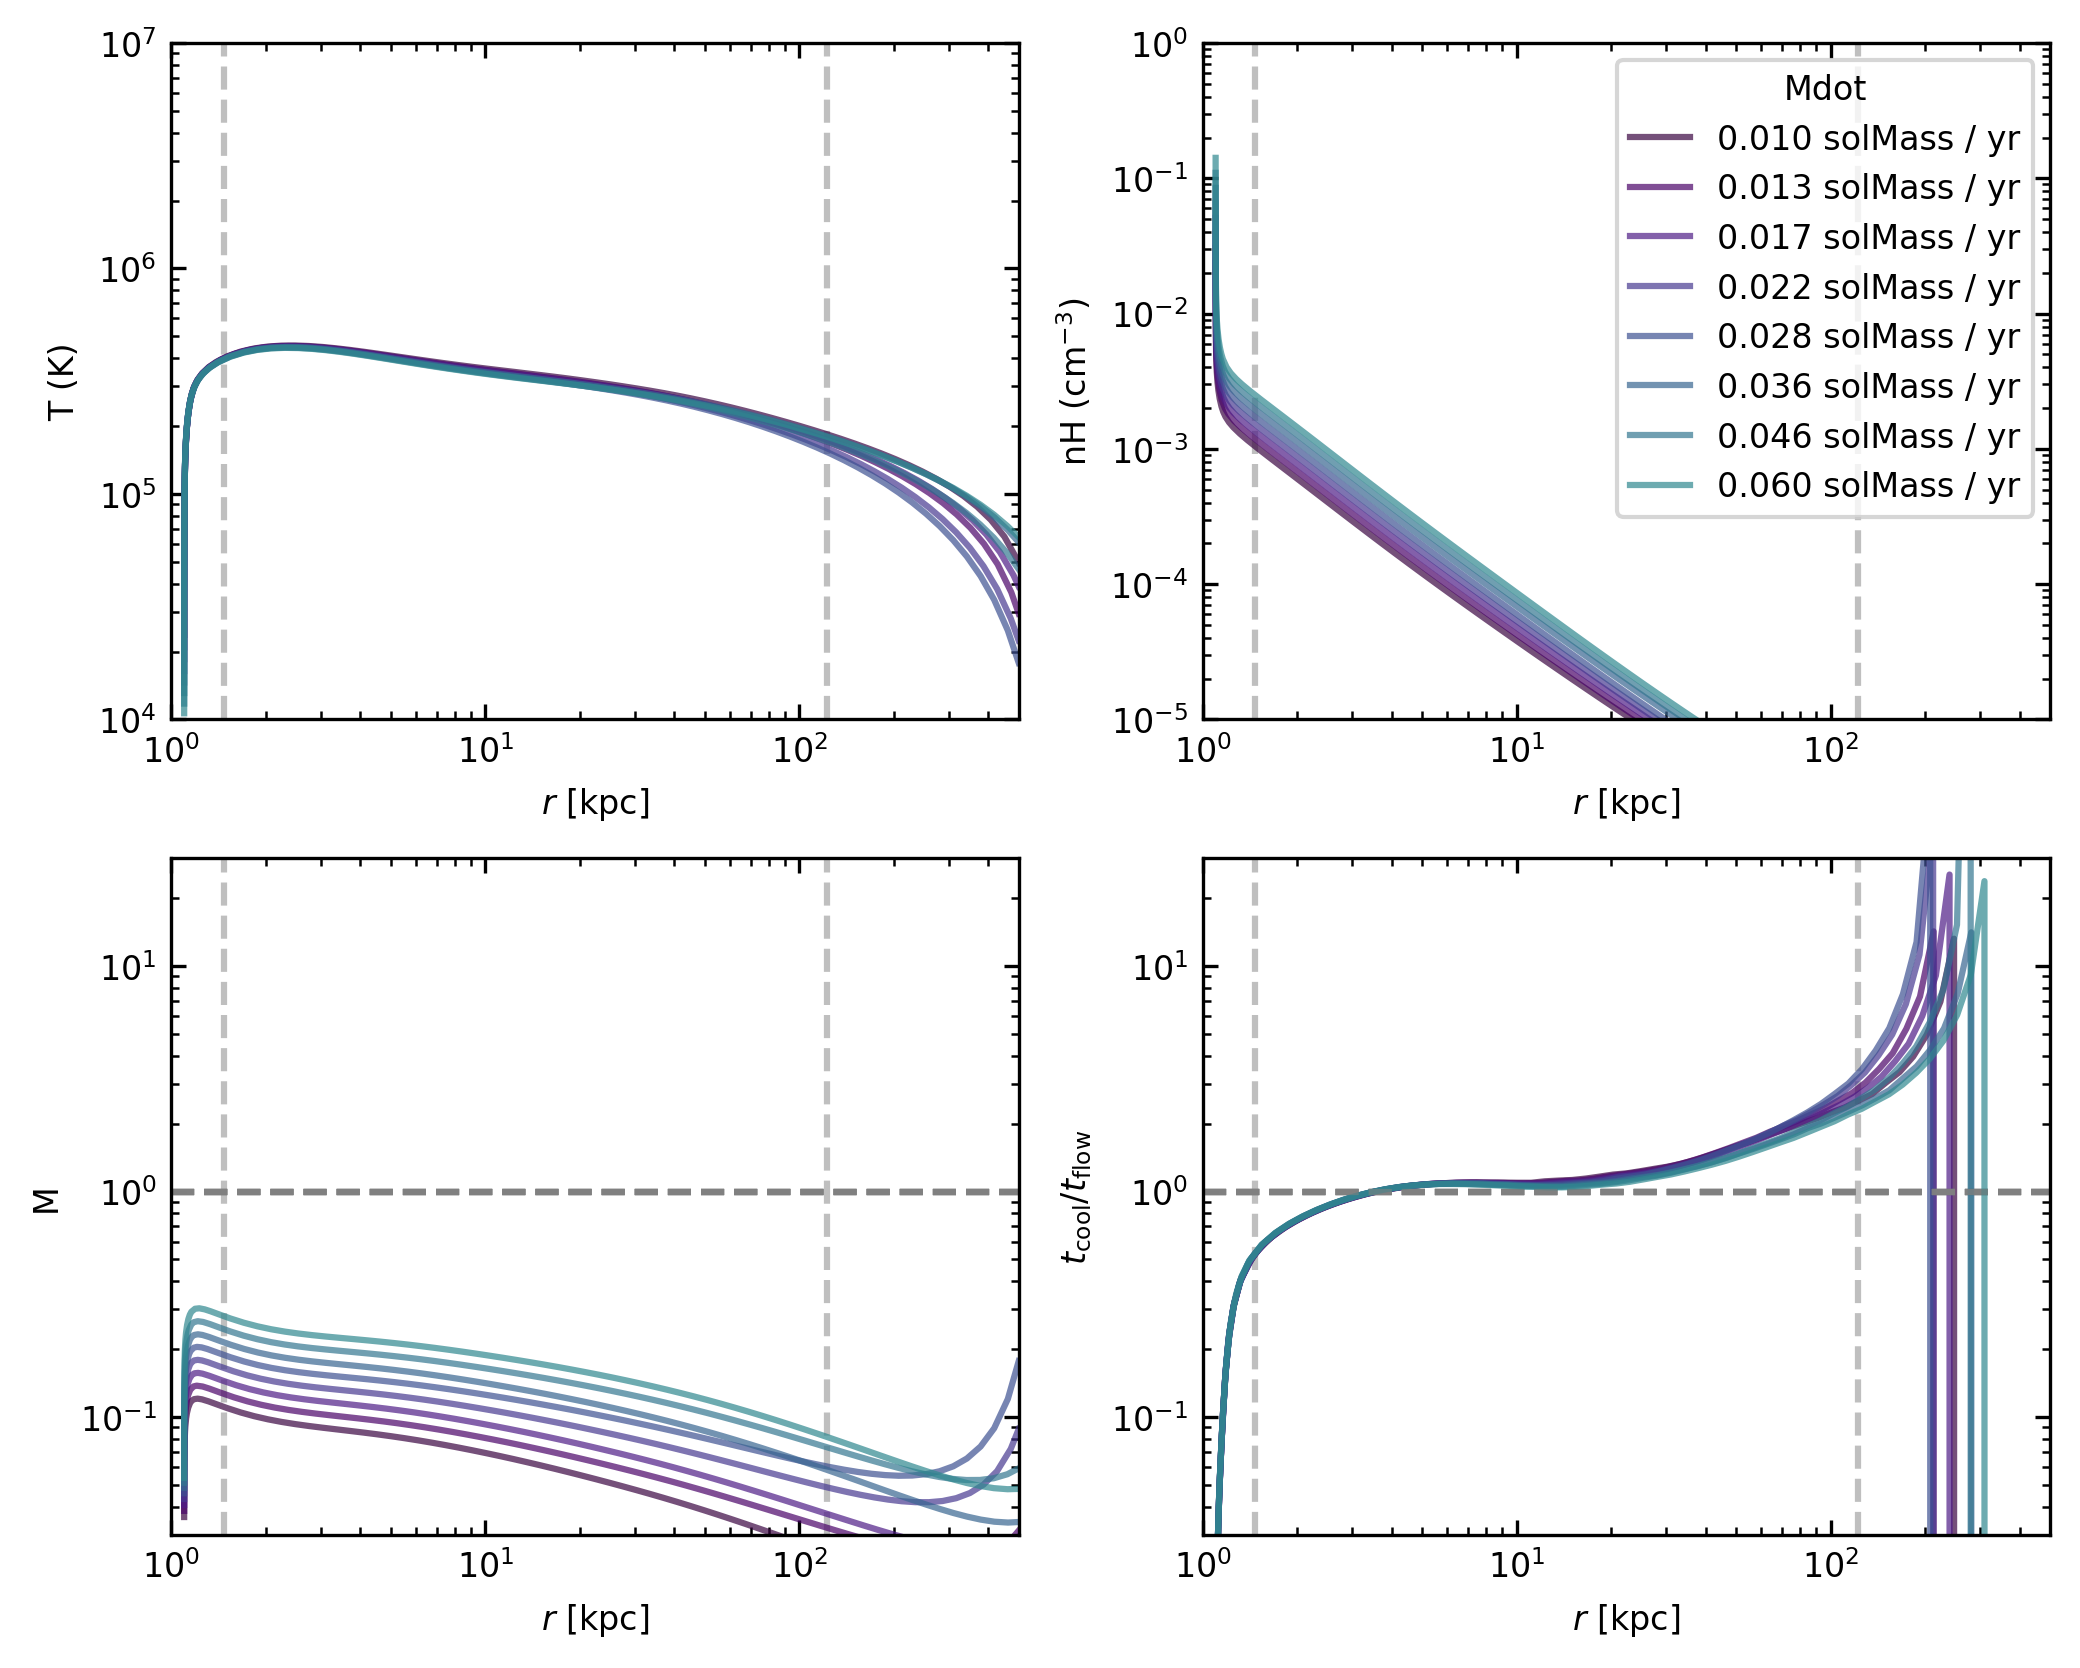

In [91]:
latexify(columns=2)
fig, axs = plt.subplots(2, 2)

for ax in axs.flatten():
    ax.set_xlabel(r'$r$ [kpc]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(top=True, right=True, which="both", direction='in')
    ax.set_xlim(1,500)

    ax.axvline(r_gal,c='.5',ls='--',alpha=0.5)
    ax.axvline(r_vir,c='.5',ls='--',alpha=0.5)

# sols = list(stalled_solutions[0].values())
colors = cmr.lavender(np.linspace(0.2,0.8,len(stalled_solutions)))
for i in range(len(stalled_solutions)):
    res = stalled_solutions[i]
    if res is not None:
        axs[0, 0].plot(res.Rs, res.Ts, alpha=0.7, color=colors[i])
        axs[0, 0].set_ylabel(r'T (K)')
        axs[0, 0].set_ylim(1e4,1e7)
        
        axs[0, 1].plot(res.Rs, res.nHs, alpha=0.7, color=colors[i], label=f'{Mdots[i]:.3f}')
        axs[0, 1].set_ylabel(r'nH (cm$^{-3}$)')
        axs[0, 1].set_ylim(1e-5,1)
        
        axs[1, 0].plot(res.Rs, res.Ms, alpha=0.7, color=colors[i])
        axs[1, 0].set_ylabel(r'M')
        axs[1, 0].set_ylim(0.03,30)
        axs[1, 0].axhline(1.,c='.5',ls='--',alpha=0.5)
        
        axs[1, 1].plot(res.Rs, res.t_cools / res.t_flows, alpha=0.7, color=colors[i])
        axs[1, 1].set_ylabel(r'$t_{\rm cool}/t_{\rm flow}$')
        axs[1, 1].set_ylim(0.03,30)
        axs[1, 1].axhline(1.,c='.5',ls='--',alpha=0.5)

axs[0, 1].legend(frameon=True, loc='upper right', title=r'Mdot', handlelength=1.8)
plt.tight_layout()
plt.show()